**Extracting Dataset**

In [1]:
import zipfile

# Path to the zip file and extract destination
zip_file_path = '/content/archive.zip'
extract_to = '/content/dataset/'

# Unzipping
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipping completed.")

Unzipping completed.


**Installing Libraries:**

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
# from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2025-01-16 15:18:54.140743: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 15:18:54.226516: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, InputLayer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [4]:
import tensorflow as tf
tf.__version__

'2.16.1'

In [5]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [6]:
df=pd.read_csv('dataset1/labels.csv')

In [7]:
df=df.loc[df['label']!='contempt']
df = df.reset_index(drop=True)
df.shape

(24931, 4)

In [8]:
df.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


In [9]:
df['label'].value_counts()

label
surprise    4616
happy       4336
anger       3608
disgust     3472
fear        3043
sad         2995
neutral     2861
Name: count, dtype: int64

In [10]:
x=[]
y=[]
emotions = ['surprise', 'happy', 'anger', 'disgust', 'fear', 'sad', 'neutral']

data_dir='dataset1/'

for df_index in range(len(df)):
    img_path=os.path.join(data_dir, df['pth'][df_index])
    img=cv2.imread(img_path)
    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(image_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) > 0:
        # If faces are detected, crop the first face
        x1, y1, w, h = faces[0]
        face_crop_img = img[y1:y1+h, x1:x1+w]
        face_crop_img = cv2.cvtColor(face_crop_img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(face_crop_img, (96, 96))
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (96, 96))


    x.append(img)
    y.append(emotions.index(df['label'][df_index]))

x=np.array(x)
y=np.array(y)

In [11]:
x=x/255.0
y = to_categorical(y, num_classes=len(emotions))

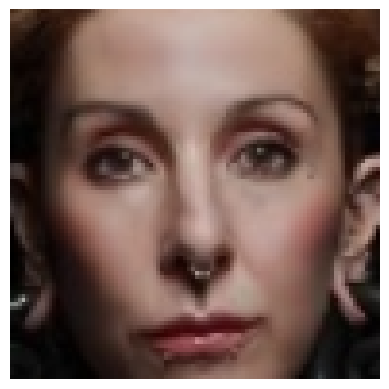

neutral
[0. 0. 0. 0. 0. 0. 1.]


In [12]:
def plot_img(i):
    plt.imshow(x[i])
    plt.axis('off')
    plt.show()
    print(df['label'][i])
    print(y[i])
plot_img(3292)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=2)

In [14]:
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(19071, 96, 96, 3) (2120, 96, 96, 3) (3740, 96, 96, 3)
(19071, 7) (2120, 7) (3740, 7)


In [15]:
# Load ResNet50 without the top layer
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze all layers in the base ResNet50v2 model
for layer in base_model.layers[:-50]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(emotions), activation='softmax')(x)  # Adjust number of classes as needed

model = Model(inputs=base_model.input, outputs=output)

2025-01-16 15:20:59.554332: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-16 15:20:59.609173: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-16 15:20:59.609621: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 24, 24,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 24, 24,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 26, 26,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 24,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 24, 24,    │          0 │ conv2_block1_0_c

 Total params: 23,579,143 (89.95 MB)

 Trainable params: 16,366,599 (62.43 MB)

 Non-trainable params: 7,212,544 (27.51 MB)

In [17]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [18]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpointer = [
    EarlyStopping(monitor='val_loss', verbose=1, restore_best_weights=True, mode="min", patience=12),
    ModelCheckpoint('best_model(1).keras', monitor="val_loss", verbose=1, save_best_only=True, mode="min")
]

In [19]:
# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=64,
    epochs=60,
    verbose=1,
    callbacks=checkpointer
)


Epoch 1/60


I0000 00:00:1737021366.315068 1123314 service.cc:145] XLA service 0x7065ac0163d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737021366.316680 1123314 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-01-16 15:26:06.479614: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-16 15:26:07.209820: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1737021367.979855 1123497 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_7440', 2328 bytes spill stores, 2324 bytes spill loads

I0000 00:00:1737021368.020878 1123493 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_7440', 360 bytes spill stores, 360 bytes spill loads



  7/298 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - Precision: 0.1891 - Recall: 0.0314 - accuracy: 0.2126 - loss: 2.2134        

I0000 00:00:1737021372.841606 1123314 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


297/298 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Precision: 0.6432 - Recall: 0.2766 - accuracy: 0.4700 - loss: 1.4031

I0000 00:00:1737021380.408657 1123604 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_7440', 1024 bytes spill stores, 664 bytes spill loads

I0000 00:00:1737021380.440379 1123596 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_7440', 528 bytes spill stores, 380 bytes spill loads



298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - Precision: 0.6434 - Recall: 0.2770 - accuracy: 0.4703 - loss: 1.4024

I0000 00:00:1737021387.585760 1123731 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1537', 528 bytes spill stores, 380 bytes spill loads




Epoch 1: val_loss improved from inf to 1.40235, saving model to best_model(1).keras
298/298 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - Precision: 0.6436 - Recall: 0.2773 - accuracy: 0.4705 - loss: 1.4017 - val_Precision: 0.5735 - val_Recall: 0.4193 - val_accuracy: 0.5066 - val_loss: 1.4024
Epoch 2/60
296/298 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Precision: 0.7722 - Recall: 0.5749 - accuracy: 0.6841 - loss: 0.8621
Epoch 2: val_loss improved from 1.40235 to 1.02434, saving model to best_model(1).keras
298/298 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - Precision: 0.7721 - Recall: 0.5749 - accuracy: 0.6841 - loss: 0.8623 - val_Precision: 0.6960 - val_Recall: 0.5627 - val_accuracy: 0.6311 - val_loss: 1.0243
Epoch 3/60
297/298 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - Precision: 0.8287 - Recall: 0.7168 - accuracy: 0.7758 - loss: 0.6062
Epoch 3: val_loss did not improve from 1.02434
298/298 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - Precision: 0.8285 - Recall: 0.7167 - accuracy: 0.7757 - loss: 0.6066 - val_Precision: 0

In [20]:
from tensorflow.keras.models import load_model

model = load_model('best_model(1).keras')

In [21]:
loss = model.evaluate(x_test,y_test)
print("Test Loss:", loss[0])
print("Test Accuracy:", loss[1])

I0000 00:00:1737021594.241160 1125244 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1537', 360 bytes spill stores, 360 bytes spill loads

I0000 00:00:1737021594.270092 1125245 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1537', 2328 bytes spill stores, 2324 bytes spill loads



115/117 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.7014 - Recall: 0.5617 - accuracy: 0.6271 - loss: 1.0014

I0000 00:00:1737021597.658131 1125298 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1537', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1737021597.709363 1125292 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1537', 528 bytes spill stores, 380 bytes spill loads

I0000 00:00:1737021597.763358 1125289 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1537', 1008 bytes spill stores, 664 bytes spill loads



117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - Precision: 0.7011 - Recall: 0.5615 - accuracy: 0.6271 - loss: 1.0018
Test Loss: 1.0163136720657349
Test Accuracy: 0.624331533908844


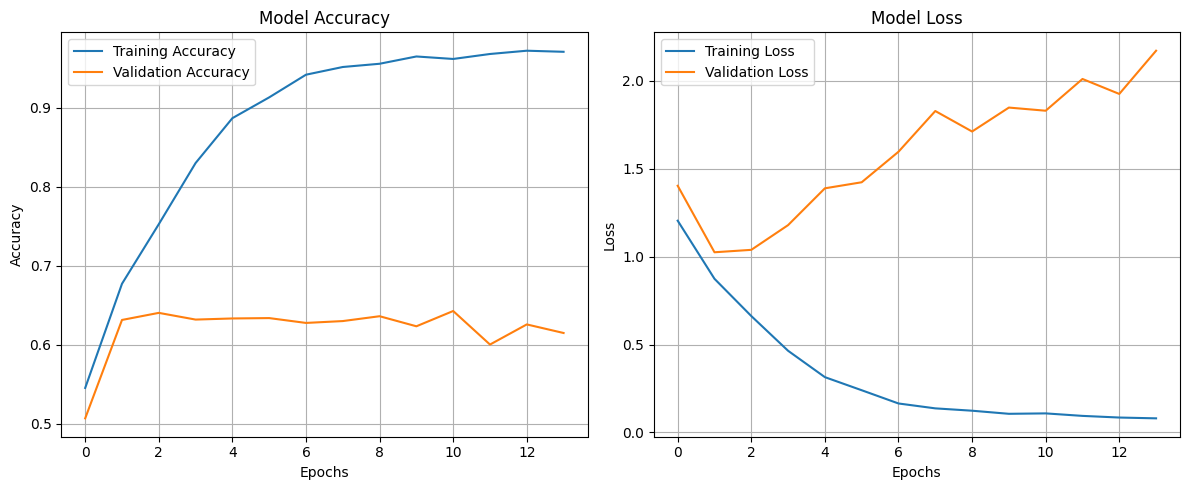

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()

In [23]:
preds = model.predict(x_test)
y_pred = np.argmax(preds , axis = 1 )

117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


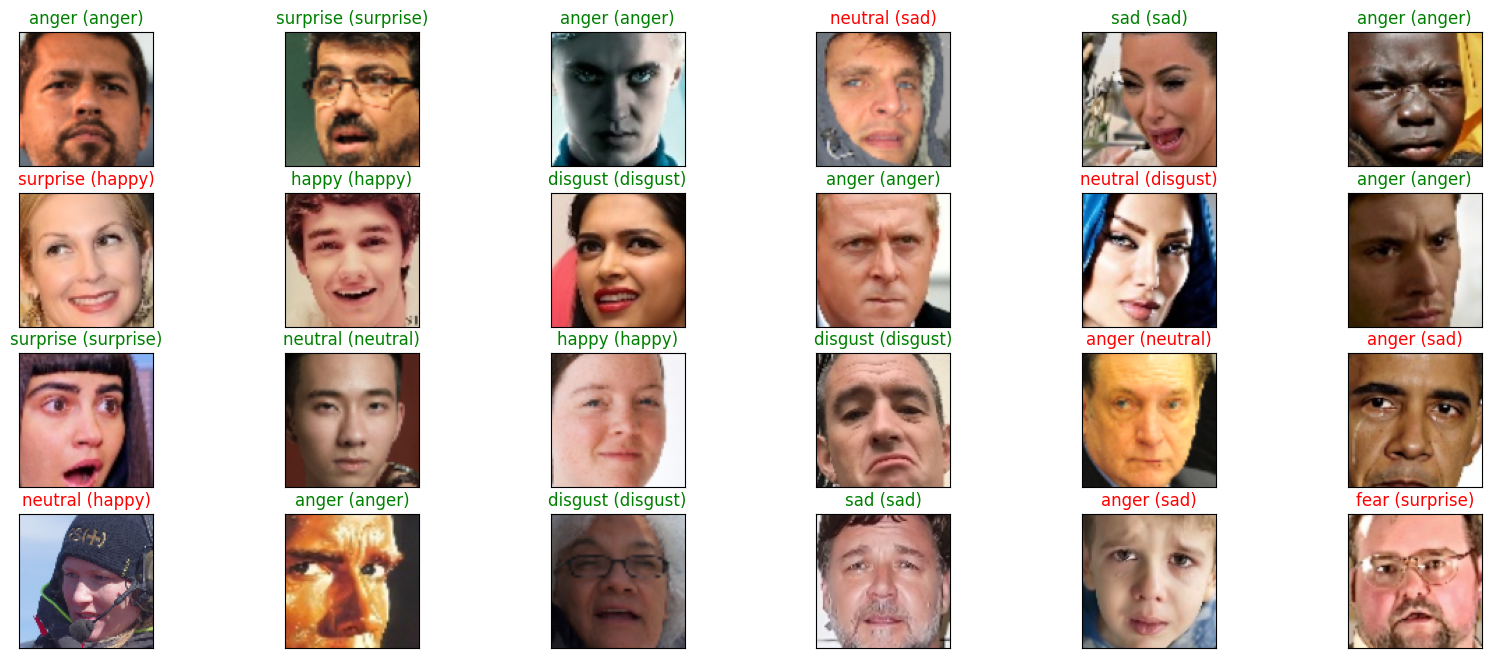

In [27]:
label_dict = {0 : 'surprise', 1 : 'happy', 2 : 'anger', 3 : 'disgust', 4 : 'fear', 5 : 'sad', 6 : 'neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

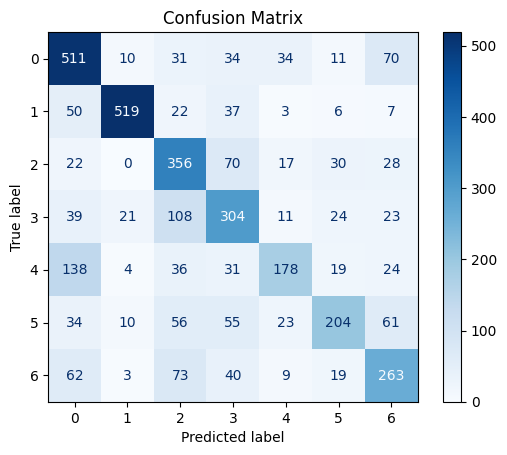

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.argmax(y_test , axis = 1 )
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
